# INFO F422 - Statistical Fundation of Machine Learning
## Project "House Prices : Advanced Regression Techniques"

    Erica Berghman
    Master 1 - Brussels Engineer School

## Abstract

## 1. Introduction 

> with dataset description, goals, and an overview of the report structure 

> Starting from a data set with 81 criteria about houses and their selling price, the goal is to create a model capable of predicting the price of other houses given some of these criterias. A good model description is a model that has been refined multiple types. This report will show the methodology used to construct a model for this particular problem. It is based on the methodology of the Chapter 6 of the syllabus.

## 2. Preprocessing 

In [18]:
dataSample = 400
mean = T          # variable to determine if we use the mean or the median to replace the NA values
set.seed(3)

source("functions/replaceNA.R")
# Hide warnings
options(warn=-1)
print = T

In order to get a model, the data must be preprocessed. Firstly we read the data given and we take a sample set of 400 houses out of the 1460. There is 81 criteria.

In [19]:
data<-read.csv("input/train.csv")
data.sample<-data[sample(nrow(data),dataSample),]
if (print) {
    dim(data.sample)
    data[1:2,]
}

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500


## 2.1 Categorical criteria

The categorical (factor) criterias are removed.

In [20]:
factor_variables<-which(sapply(data.sample[1,],class)=="factor")
data.sample.nofactor<-data.sample[,-factor_variables]
data.sample.factor<-data.sample[,factor_variables]
if (print) summary(data.sample.factor)

    MSZoning    Street     Alley     LotShape  LandContour  Utilities  
 C (all):  1   Grvl:  0   Grvl: 12   IR1:130   Bnk: 18     AllPub:399  
 FV     : 19   Pave:400   Pave: 14   IR2: 14   HLS: 14     NoSeWa:  1  
 RH     :  7              NA's:374   IR3:  2   Low:  8                 
 RL     :308                         Reg:254   Lvl:360                 
 RM     : 65                                                           
                                                                       
                                                                       
   LotConfig   LandSlope  Neighborhood   Condition1    Condition2    BldgType  
 Corner : 69   Gtl:379   NAmes  : 65   Norm   :338   Norm   :398   1Fam  :329  
 CulDSac: 29   Mod: 19   CollgCr: 37   Feedr  : 22   Artery :  1   2fmCon: 10  
 FR2    : 10   Sev:  2   OldTown: 32   Artery : 14   Feedr  :  1   Duplex: 14  
 FR3    :  0             NWAmes : 30   PosN   :  8   PosA   :  0   Twnhs : 18  
 Inside :292            

Some of them are then added. (TODO justification)

In [21]:
library(dummies)
variable_to_keep<-c("CentralAir", "Street", "LotShape")
data_factor_onehot <- dummy.data.frame(data.sample.factor[,variable_to_keep], sep="_")
data.nofactor.extended<-cbind(data.sample.nofactor,data_factor_onehot)

### 2.2 Missing data 
The missing values (NA) are replaced by an estimator of these values (eg. mean or median).

In [22]:
if (mean) {
    data_preprocessed<-data.frame(apply(data.nofactor.extended,2,replace_na_with_mean_value)) 
} else {
    data_preprocessed<-data.frame(apply(data.nofactor.extended,2,replace_na_with_median_value))
}

## 3. Feature selection 
> Methodology and main results

> The text must contain the list of selected variables and the motivation of their choice. The use of formulas, tables and pseudo-code to describe the feature selection procedure is encouraged. 

### 3.1 Redundant and irrelevant features 
The "Id" column which is irrelevant is deleted.

In [23]:
data_preprocessed<-data_preprocessed[,setdiff(colnames(data_preprocessed),"Id")]

The criterias that are redundant (linear combination of others criterias and correlation > 0.99) are deleted.

In [25]:
#library(caret)
library(ggplot2)
library(lattice)

#linearCombo.idx <- findLinearCombos(data_preprocessed)$remove
#if (!is.null(linearCombo.idx)) data_preprocessed<-data_preprocessed[,-linearCombo.idx]

correlation.matrix <- cor(data_preprocessed)
correlation.matrix[upper.tri(correlation.matrix)] <- 0
diag(correlation.matrix) <- 0
data.uncorrelated <- data_preprocessed[,!apply(correlation.matrix,2,function(x) any(abs(x) > 0.99))]
if (print) dim(data.uncorrelated)

MSSubClass   LotFrontage       LotArea   OverallQual   OverallCond 
        FALSE         FALSE         FALSE         FALSE         FALSE 
    YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1    BsmtFinSF2 
        FALSE         FALSE         FALSE         FALSE         FALSE 
    BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF  LowQualFinSF 
        FALSE         FALSE         FALSE         FALSE         FALSE 
    GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath      HalfBath 
        FALSE         FALSE         FALSE         FALSE         FALSE 
 BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces   GarageYrBlt 
        FALSE         FALSE         FALSE         FALSE         FALSE 
   GarageCars    GarageArea    WoodDeckSF   OpenPorchSF EnclosedPorch 
        FALSE         FALSE         FALSE         FALSE         FALSE 
   X3SsnPorch   ScreenPorch      PoolArea       MiscVal        MoSold 
        FALSE         FALSE         FALSE         FALSE         FALSE 
       YrSold     SalePrice  CentralAir_N  CentralAir_Y  LotShape_IR1 
        FALSE         FALSE          TRUE         FALSE         FALSE 
 LotShape_IR2  LotShape_IR3  LotShape_Reg 
        FALSE         FALSE         FALSE

[1] 400  42

The input and output vectors are created and scaled.

In [26]:
X <- data.uncorrelated[,setdiff(colnames(data.uncorrelated),"SalePrice")]
Y <- data.uncorrelated[,"SalePrice"]
X <- data.frame(X)
#Y <- data.frame(Y)
X.scale <- data.frame(scale(X))
Y.scale <- scale(Y)

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

In [27]:
if (print) dim(X)
#X.tr.mean <- colMeans(X)
#X.tr.std <- apply(X,2,sd)

[1] 400  41

### 3.2 Filter methods

   It create a subset of features, removing from the whole features set the ones less likely to determine the variable (SalePrice). It is robust to overfitting and effective in computational time. However it might select redundant variables as the interraction between the variables is not taken in consideration.  

In [ ]:
source("functions/filtre.R")
features.filtre <- filtre(X.scale,Y.scale)  # return the idx of the more correlated features where #feature = argmin(CV error)

In [ ]:
X.filtre = X.scale[,features.filtre]
if (print) {
    dim(X.filtre)
    X.filtre[1:2,]
}    

In [ ]:
source("functions/mRMR.R")
features.mrmr <- mrmr(X.scale, Y.scale)    # return the idx of the more correlated features where #feature = argmin(CV error)

In [ ]:
X.mrmr <- X.scale[,features.mrmr]
if (print) dim(X.mrmr)

In [ ]:
source("functions/pca.R")
X.pca <- pca(X.scale, Y.scale)   # return X_pca with nb of columns = argmin(CV error)
if (print) dim(X.pca)

### 3.3 Wrapper method

Its a cyclic method where a subset of variable is created and evaluated by the Learning Algorithm, modifying the chosen subset. This is done until the best subset is generated.  

In [ ]:
source("functions/wrapper.R")
features.wrapper <- wrapper(X.scale, Y.scale)

In [ ]:
X.wrapper <- X[,features.wrapper]
if (print) dim(X.wrapper)

### 3.4 Hybrid method
The filter method is used to select a first "big" set of features, that is then refined by the wrapper method. This gives us the possibility use advantages of both method to get a good subset in a relatively correct computational time.

In [ ]:
features.wrapper.pca <- wrapper(X.pca, Y.scale)

## 4. Model selection  
> Methodology and main results

> For the learning method, the only packages that may be used are those seen during the exercise classes : stats, nnet, tree, lazy, and e1071, for linear models, neural networks, decision trees, nearest neighbours and SVM, respectively.

> The accuracy of the regression models during the selection process should be assessed by using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sale price.

> The text must mention the different (and at least three) models which have been taken into consideration and the procedure used for model assessment and selection. The use of formulas, tables and pseudo-code to describe the feature selection procedure is encouraged

### 4.1 Linear Model

In [28]:
library(stats)

In [29]:
DS<-cbind(X.scale,SalePrice=Y.scale)
model.linear <- lm(SalePrice~.,DS) ### IMDB score given all the other ones (~.) over the dataset DS

Y.hat <- predict(model.linear, X.scale)

empirical_error<-mean((Y.hat-Y.scale)^2) ### MSE for prediction of that model.
if (print) print(paste("Empirical error=",round(empirical_error,digits=4)))

[1] "Empirical error= 0.1201"


In [47]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
    # 1/10 for testing
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]    
    
    #9/10 for training
     i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]         
     
    #scaling
     X.tr.mean <- colMeans(X.tr)
     X.tr.sd <- apply(X.tr,2,sd)
    Y.tr.mean <- mean(Y.tr)
    Y.tr.sd <- sd(Y.tr)
    Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
    X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    
    #scaling the testing test by the same scaling as of the training set
    X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 
    
    X.ts <-data.frame(X.ts)
    X.tr <-data.frame(X.tr)
        
    DS<-cbind(X.tr,SalePrice=Y.tr)
  
    # delete column with only NAs (due to dividing by a std of 0)    
    DS<- DS[,colSums(!is.na(DS)) > 0]    

    model.linear<- lm(SalePrice~.,DS)      # create model with the training set
    Y.hat.ts<- predict(model.linear,X.ts)  # predict value for the test set
        
    CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)  # MSE for test set
}
    
print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))

[1] "CV error= 0.1645  ; std dev= 0.073"


### 4.2 Decision tree

In [49]:
library(rpart)

In [50]:
DS<-cbind(X.scale,SalePrice=Y.scale)
model.tree <- rpart(SalePrice~.,DS)
        
Y.hat <- predict(model.tree,X.scale)
        
empirical_error<-mean((Y.hat-Y.scale)^2) 
print(paste("Empirical error=",round(empirical_error,digits=4)))

[1] "Empirical error= 0.1793"


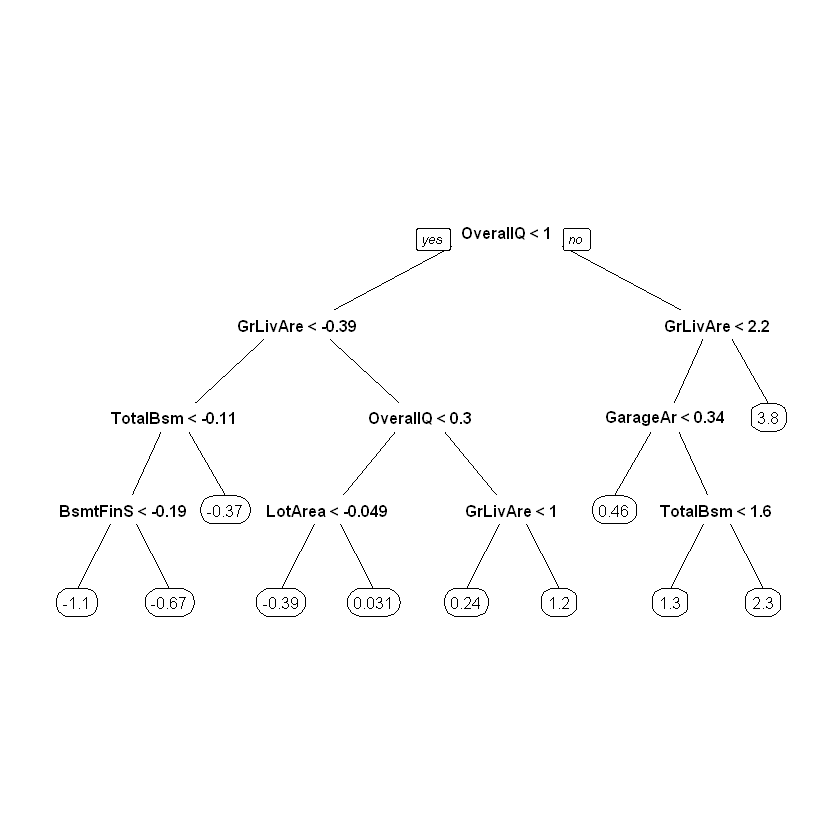

In [51]:
library(rpart.plot)
prp(model.tree)

Decision tree gives a good overview on what criteria are important. It wears its name well as it help you decide the value of the price given a set of caracteristics.

#### Cross validation

In [52]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
    # 1/10 for testing
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]    
    
    #9/10 for training
     i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]         
     
    #scaling
     X.tr.mean <- colMeans(X.tr)
     X.tr.sd <- apply(X.tr,2,sd)
    Y.tr.mean <- mean(Y.tr)
    Y.tr.sd <- sd(Y.tr)

    Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
    X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    
    #scaling the testing test by the same scaling as of the training set
    X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 
    
    X.ts <-data.frame(X.ts)
    X.tr <-data.frame(X.tr)                       
     
    DS<-cbind(X.tr,SalePrice=Y.tr)
    DS<- DS[,colSums(!is.na(DS)) > 0]    
        
    model<- rpart(SalePrice~.,DS)
        
    Y.hat.ts<- predict(model.tree,X.ts)
        
    CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
}
    

print(paste("CV error =",round(mean(CV.err),digits=4), " std dev =",round(sd(CV.err),digits=4)))


[1] "CV error = 0.1934  std dev = 0.0577"


### 4.3 Neural network

In [53]:
library(nnet)

In [54]:
DS<-cbind(X.scale,SalePrice=Y.scale)
empirical_error <- numeric(20)

for (i in 1:20){
    #model.neural[i] <- nnet(SalePrice~.,DS, size = i, linout=T, maxit = 1000)
    Y.hat <- predict(nnet(SalePrice~.,DS, size = i, linout=T, maxit = 1000),X.scale)

    empirical_error[i] <- mean((Y.hat-Y.scale)^2) 
    print(paste("Number of neurones: ", i, "Empirical error = ",round(empirical_error[i],digits=4)))
}

# weights:  216
initial  value 405.346557 
iter  10 value 71.807642
iter  20 value 37.024349
iter  30 value 22.612993
iter  40 value 16.651721
iter  50 value 14.215580
iter  60 value 12.941675
iter  70 value 12.042986
iter  80 value 11.384322
iter  90 value 10.966827
iter 100 value 10.220278
iter 110 value 9.968853
iter 120 value 9.878128
iter 130 value 9.700413
iter 140 value 9.368363
iter 150 value 9.015004
iter 160 value 8.690616
iter 170 value 8.450985
iter 180 value 8.293419
iter 190 value 8.025176
iter 200 value 7.841972
iter 210 value 7.601023
iter 220 value 7.382145
iter 230 value 7.259502
iter 240 value 7.153716
iter 250 value 7.069991
iter 260 value 6.980652
iter 270 value 6.933445
iter 280 value 6.872346
iter 290 value 6.791391
iter 300 value 6.706091
iter 310 value 6.660776
iter 320 value 6.596123
iter 330 value 6.541293
iter 340 value 6.464066
iter 350 value 6.396614
iter 360 value 6.358123
iter 370 value 6.326998
iter 380 value 6.295035
iter 390 value 6.268988
iter 400 va

#### Parameter "size"
An analysis of the number of neurones is done. The maximum of neurones used is 20 as more return an error (too many weights).


In [55]:
empirical_error
#juste un save pour les tests
#empirical_error <- c(0.0143671130358607, 0.015019445363705, 0.00821834907673351, 0.0054200745645435, 0.00142228029226354, 5.25161597874794e-05, 1.52899010549121e-06, 2.47317346679477e-07, 2.37597648006074e-07, 2.47841099771862e-07, 2.26350153783801e-07, 2.30675129791945e-07, 2.44205643742954e-07, 2.4713486169669e-07, 2.40667851762e-07, 2.31459671090645e-07, 2.39175596505192e-07, 2.24902711484879e-07) 

[1] 1.793329e-01           NA           NA           NA 1.437719e-02
 [6] 1.299284e-02 6.958540e-03 2.929424e-03 5.050835e-04 2.172340e-04
[11] 5.580610e-07 2.366264e-07 2.419139e-07 2.432441e-07 2.451866e-07
[16] 2.343481e-07 2.463664e-07 2.433855e-07 2.440302e-07 2.430354e-07
[21] 2.401956e-07 2.487036e-07

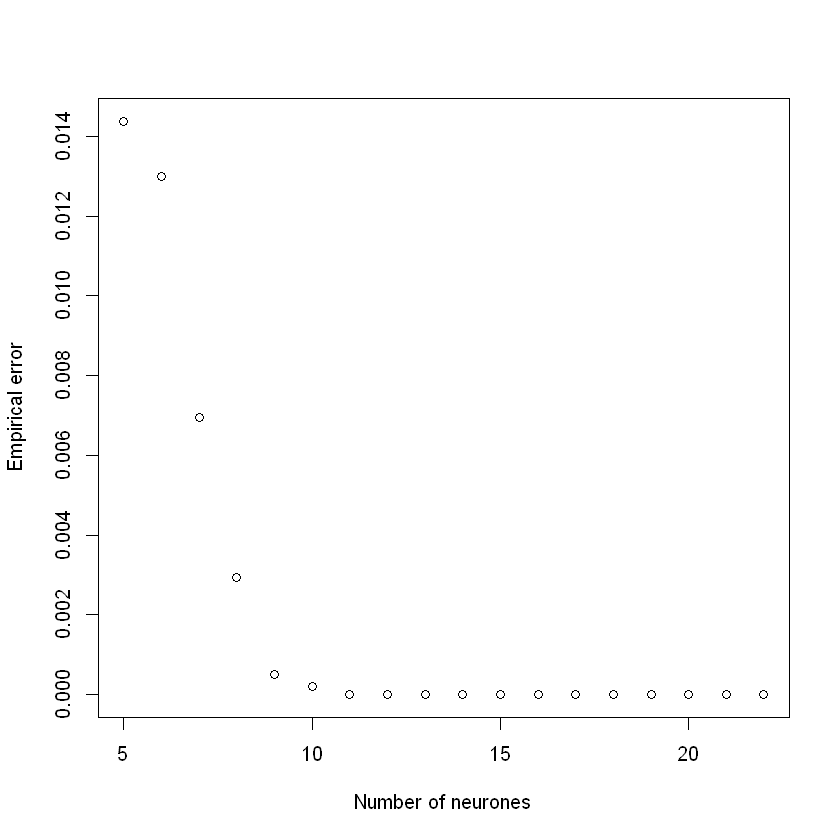

In [58]:
plot(c(5:22),empirical_error[5:22], xlab = "Number of neurones", ylab = "Empirical error")

At first view it seems like a size > 10 gives the best result. As the computational time incrases with the number of neurones, its important to find the smallest size that gives good result. We will now asses the 10-fold cross validation for the 10 models (size 10 to 20) to determine if they are good.

In [ ]:
#plot(c(12:22),empirical_error[8:18], xlab = "Number of neurones", ylab = "Empirical error")  # zoom

#### Cross validation

In [ ]:
mean.size<-numeric(20)

In [ ]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (j in 10:20){
    
    for (i in 1:10) {
        # 1/10 for testing
         i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
         X.ts<-X[i.ts,]  
         Y.ts<-Y[i.ts]    

        #9/10 for training
         i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
         X.tr<-X[i.tr,]
         Y.tr<-Y[i.tr]         

        #scaling
         X.tr.mean <- colMeans(X.tr)
         X.tr.sd <- apply(X.tr,2,sd)
        Y.tr.mean <- mean(Y.tr)
        Y.tr.sd <- sd(Y.tr)

        Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
        X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))

        #scaling the testing test by the same scaling as of the training set
        X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
        Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 

        X.ts <-data.frame(X.ts)
        X.tr <-data.frame(X.tr)                       

        DS <- cbind(X.tr,SalePrice=Y.tr)
        DS<- DS[,colSums(!is.na(DS)) > 0]    
            
        model.neural <- nnet(SalePrice~.,DS, size = j, linout=T, maxit = 1000)

        Y.hat.ts<- predict(model.neural,X.ts)

        CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
    }
    mean.size[j] <- round( mean(CV.err),digits=4 )
    print(paste("Number of neurones: ", j, " CV error = ",mean.size[j-9], " std dev = ",round(sd(CV.err),digits=4)))
}

In [ ]:
plot(c(10:20), mean.size(10:20), xlabel = "Number of neurones" , ylabel= "Cross validation error")

As we can see, the CV error is far from the ~0 we had before. This is because the model was overfitting the set. Let's see what kind of results we get for the CV with a smaller network size (<9)

In [ ]:
size.CV<-floor(N/10)

for (j in 1:9){
    
    for (i in 1:10) {
        # 1/10 for testing
         i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
         X.ts<-X[i.ts,]  
         Y.ts<-Y[i.ts]    

        #9/10 for training
         i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
         X.tr<-X[i.tr,]
         Y.tr<-Y[i.tr]         

        #scaling
         X.tr.mean <- colMeans(X.tr)
         X.tr.sd <- apply(X.tr,2,sd)
        Y.tr.mean <- mean(Y.tr)
        Y.tr.sd <- sd(Y.tr)

        Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
        X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))

        #scaling the testing test by the same scaling as of the training set
        X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
        Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 

        X.ts <-data.frame(X.ts)
        X.tr <-data.frame(X.tr)                       

         DS <- cbind(X.tr,SalePrice=Y.tr)
         DS<- DS[,colSums(!is.na(DS)) > 0]    
            
         model.neural <- nnet(SalePrice~.,DS, size = j, linout=T, maxit = 1000)

         Y.hat.ts<- predict(model.neural,X.ts)

         CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
        }
    mean.size[j] <- round( mean(CV.err),digits=4 )
    print(paste("Number of neurones: ", j, " CV error = ",mean.size[j], " std dev = ",round(sd(CV.err),digits=4)))
}

In [ ]:
plot(c(3:9), mean.size[1:9], xlabel = "Number of neurones" , ylabel= "Cross validation error")

In [ ]:
mean.size[1:9]

## Ensemble techniques : Combination of models strategy
> Methodology and main results

> The text should mention the different models taken into consideration as well as the techniques used for the combination.

In [ ]:
size.CV<-floor(N/10)
R<-20   # R models

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     
     i.tr<-setdiff(1:N,i.ts)                
    
     Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
     for (r in 1:R) {
         i.tr.resample<-sample(i.tr,rep=T)  #rep = replace
         X.tr<-X[i.tr.resample,]
         Y.tr<-Y[i.tr.resample]                          
     
         DS<-cbind(X.tr,SalePrice=Y.tr)
    
         model<- lm(SalePrice~.,DS)
        
         Y.hat.ts.R[,r]<- predict(model,X.ts)
     
     }
    
     Y.hat.ts<-apply(Y.hat.ts.R,1,mean) 
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
     }

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))


## Discussion and conclusion: 
> Summary of your work, and discussion of what worked well, not well, why, what insights you got from the analyses you made. 